# Arbitrage Strategy Based on Book-to-Market

This notebook implements an arbitrage model based on the spread between accounting value (book value) and market value of major listed companies.
Enhancements include:
- Sector neutrality
- Transaction cost adjustments
- Combined value signals (Book-to-Market and Free Cash Flow Yield)
- Quality filtering (positive earnings, low accruals)

## Theoretical Framework

Let:
- $P_{i,t}$ = Price of stock *i* at time *t*
- $BVPS_{i,t}$ = Book Value per Share
- $MV_{i,t} = P_{i,t} \times Shares$
- $BV_{i,t} = BVPS_{i,t} \times Shares$

### Value Signal:
We consider book value to market capitalization ratio: how much accounting value is paid for by the market
$$
BTM_{i,t} = \frac{BV_{i,t}}{MV_{i,t}}
$$

### FCF Yield:
$$
FCFY_{i,t} = \frac{FCF_{i,t}}{MV_{i,t}}
$$

### Composite Signal (Z-Score):
$$
Z_{i,t} = \frac{(Signal_{i,t} - \mu_t)}{\sigma_t}
$$
Where $Signal_{i,t}$ combines BTM and FCFY, and $\mu_t$, $\sigma_t$ are cross-sectional mean and std.

We go **long** on stocks with low Z and **short** on high Z, adjusted for sector neutrality.

Should switch to dynamic book value calculation.

In [ ]:
# Requirements and setup for the project
%pip install -r ./requirements.txt
!mkdir -p ./data
!if [ ! -f ./.env ]; then echo "Please create a .env file with your ALPHA_VANTAGE_API_KEY."; fi

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import os
from datetime import date
from datetime import datetime as dt
import glob

from utils import get_fundamentals, compute_book_value_per_share, next_quarter, load_fundamentals

In [ ]:
# CONFIG FOR AV + FETCH NEW DATA
# Ideally, only run a few times since key usage is limited
# TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'GTLB'] already done
TICKERS = ['TSLA','AI', 'AEO', 'KER', '1MC', 'BUD']
function_map = {'b': 'BALANCE_SHEET', 'i': 'INCOME_STATEMENT', 'c': 'CASH_FLOW'}
fundamentals = {}

for ticker in TICKERS:
    overview = get_fundamentals(ticker, function='o')
    pd.DataFrame([overview]).to_csv(f'./data/overview_{ticker}.csv', index=False)
    fundamentals[(ticker, 'current', 'OVERVIEW')] = overview

    for function in ['b', 'i', 'c']:
        reports = get_fundamentals(ticker, function=function)
        pd.DataFrame(reports).to_csv(f'./data/{function}_{ticker}.csv', index=False)
        fundamentals.update({(ticker, report['fiscalDateEnding'], function_map[function]): report for report in reports})

# Convert the fundamentals dictionary to a DataFrame
fundamentals = {k: v for k, v in fundamentals.items() if v is not None}
df = pd.DataFrame(fundamentals).T
df.index.names = ['ticker', 'fiscalDateEnding', 'statementType']
df.drop(columns=['Symbol', 'fiscalDateEnding', 'statementType'], inplace=True)
df.reset_index(inplace=True)

try:
    with open(f'./data/{dt.today()}/fundamentals_{dt.today()}.csv', index_col=list(range(4))) as f:
        if f.readable():
            os.makedirs(f'./data/{dt.today()}', exist_ok=True)
            df = df.append(pd.read_csv(f, index_col=[0, 1, 2]).to_dict(orient='index'))

except FileNotFoundError:
    # Fallback to the most recent file if today's file does not exist
    files = sorted(glob.glob('./data/*/fundamentals_*.csv'), key=lambda x: dt.datetime.strptime(x.split('_')[-1].split('.')[0], '%Y-%m-%d'), reverse=True)
    
    try:
        with open(files[0], index_col=list(range(4))) as f:
            if f.readable():
                os.makedirs(f'./data/{dt.today()}', exist_ok=True)
                df = df.append(pd.read_csv(f, index_col=[0, 1, 2]).to_dict(orient='index'))

    except:
        with open('./data/fundamentals.csv', index_col=list(range(4))) as f:
            if f.readable():
                os.makedirs(f'./data/{dt.today()}', exist_ok=True)
                df = df.append(pd.read_csv(f, index_col=[0, 1, 2]).to_dict(orient='index'))


df.to_csv(f'./data/{dt.today()}/fundamentals_{dt.today()}.csv')
pd.DataFrame({'Attributes': df.columns.tolist()}).to_csv(f'./data/{dt.today()}/attributes_{dt.today()}.csv', index=False)
df = None  # Clear memory

In [ ]:
# Prepare attributes + Check if same metrics are present in different statements
# Net Income appears in both income statement and cash flow statement; not always same values
b = pd.read_csv('./data/b_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
bc = b.columns.to_list()
i = pd.read_csv('./data/i_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
ic = i.columns.to_list()
c = pd.read_csv('./data/c_AAPL.csv', index_col='fiscalDateEnding', parse_dates=True)
cc = c.columns.to_list()
o = pd.read_csv('./data/overview_AAPL.csv', parse_dates=True)
oc = o.columns.to_list()

#print('Balance Sheet & Overview:', set(bc) & set(oc))
#print('Income & Overview:', set(ic) & set(oc))
#print('Cash Flow & Overview:', set(cc) & set(oc))
print('Balance Sheet & Income:', set(bc) & set(ic))
print('Balance Sheet & Cash Flow:', set(bc) & set(cc))
print('Income & Cash Flow:', set(ic) & set(cc))
print(i[['netIncome']].iloc[-3:], c[['netIncome']].iloc[-3:])

Balance Sheet & Income: {'reportedCurrency'}
Balance Sheet & Cash Flow: {'reportedCurrency'}
Income & Cash Flow: {'netIncome', 'reportedCurrency'}
                  netIncome
fiscalDateEnding           
2005-09-30        430000000
2005-06-30        319000000
2005-03-31        290000000                   netIncome
fiscalDateEnding           
2005-09-30        430000000
2005-06-30        315000000
2005-03-31        290000000


In [4]:
# Load the latest file
try:
    fundamentals = pd.read_csv(f'./data/{dt.today()}/fundamentals_{dt.today()}.csv', index_col=list(range(4)))
except FileNotFoundError:
    # Fallback to the most recent file if today's file does not exist
    files = sorted(glob.glob('./data/*/fundamentals_*.csv'), key=lambda x: dt.datetime.strptime(x.split('_')[-1].split('.')[0], '%Y-%m-%d'), reverse=True)
    try:
        fundamentals = pd.read_csv(files[0], index_col=list(range(4)))
    except:
        fundamentals = pd.read_csv('./data/fundamentals.csv', index_col=list(range(4)))

# Remove rows with NaN values in all columns
fundamentals = fundamentals.dropna(how='all')

# Convert the DataFrame to numeric columns that start with a digit
fundamentals = fundamentals.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.astype(str).str.contains(r'^\d', na=False).any() else x)
fundamentals = fundamentals.pivot_table(index=['ticker', 'fiscalDateEnding'], columns='statementType', values=bc + ic + cc + [col for col in oc if col not in ['Symbol']], aggfunc='first')
fundamentals.columns = fundamentals.columns.swaplevel(0, 1)
fundamentals.reset_index(inplace=True)
fundamentals = fundamentals.set_index(['ticker', 'fiscalDateEnding'])

# Filter out companies with negative EPS or profit margin
# We need keep any line with tickers s.t. its ('OVERVIEW','DilutedEPSTTM') column is > 0:
viable_tickers = fundamentals.where(
    (fundamentals['OVERVIEW']['DilutedEPSTTM'] > 0) & (fundamentals['OVERVIEW']['ProfitMargin'] > 0)
).index.get_level_values('ticker').unique()
fundamentals = fundamentals[fundamentals.index.get_level_values('ticker').isin(viable_tickers)]
# Calculate Book value per Share
fundamentals = compute_book_value_per_share(fundamentals)

fundamentals.head()

statementType                      OVERVIEW                                \
                        200DayMovingAverage 50DayMovingAverage 52WeekHigh   
ticker fiscalDateEnding                                                     
AAPL   2005-03-31                       NaN                NaN        NaN   
       2005-06-30                       NaN                NaN        NaN   
       2005-09-30                       NaN                NaN        NaN   
       2005-12-31                       NaN                NaN        NaN   
       2006-03-31                       NaN                NaN        NaN   

statementType                                                         \
                        52WeekLow AnalystRatingBuy AnalystRatingHold   
ticker fiscalDateEnding                                                
AAPL   2005-03-31             NaN              NaN               NaN   
       2005-06-30             NaN              NaN               NaN   
       2005-09-30             NaN              NaN               NaN   
       2005-12-31             NaN              NaN               NaN   
       2006-03-31             NaN              NaN               NaN   

statementType                                                     \
                        AnalystRatingSell AnalystRatingStrongBuy   
ticker fiscalDateEnding                                            
AAPL   2005-03-31                     NaN                    NaN   
       2005-06-30                     NaN                    NaN   
       2005-09-30                     NaN                    NaN   
       2005-12-31                     NaN                    NaN   
       2006-03-31                     NaN                    NaN   

statementType                                                       ...  \
                        AnalystRatingStrongSell AnalystTargetPrice  ...   
ticker fiscalDateEnding                                             ...   
AAPL   2005-03-31                           NaN                NaN  ...   
       2005-06-30                           NaN                NaN  ...   
       2005-09-30                           NaN                NaN  ...   
       2005-12-31                           NaN                NaN  ...   
       2006-03-31                           NaN                NaN  ...   

statementType           BALANCE_SHEET                     \
                          totalAssets totalCurrentAssets   
ticker fiscalDateEnding                                    
AAPL   2005-03-31        1.011100e+10       8.710000e+09   
       2005-06-30        1.048800e+10       9.042000e+09   
       2005-09-30        1.155100e+10       9.969000e+09   
       2005-12-31        1.418100e+10       1.169100e+10   
       2006-03-31        1.391100e+10       1.073000e+10   

statementType                                                     \
                        totalCurrentLiabilities totalLiabilities   
ticker fiscalDateEnding                                            
AAPL   2005-03-31                  3.352000e+09     3.725000e+09   
       2005-06-30                  3.123000e+09     3.667000e+09   
       2005-09-30                  3.484000e+09     4.085000e+09   
       2005-12-31                  5.060000e+09     5.801000e+09   
       2006-03-31                  4.456000e+09     5.229000e+09   

statementType                                                             \
                        totalNonCurrentAssets totalNonCurrentLiabilities   
ticker fiscalDateEnding                                                    
AAPL   2005-03-31                1.104000e+09                373000000.0   
       2005-06-30                1.112000e+09                544000000.0   
       2005-09-30                1.251000e+09                601000000.0   
       2005-12-31                2.019000e+09                741000000.0   
       2006-03-31                2.625000e+09                773000000.0   

statementType           I

In [46]:
TICKERS = fundamentals.index.get_level_values('ticker').unique().tolist()
TRANSACTION_COST = 0.01  # 1% per trade to be conservative
START_DATE = '2005-06-30'
END_DATE = '2025-06-30'

prices = yf.download(TICKERS, start=START_DATE, end=END_DATE)
close_prices = prices['Close']

book_values, fcf_yields, accruals, market_values, sectors, earnings = {}, {}, {}, {}, {}, {}

for ticker in TICKERS:
    
    firm_data = fundamentals.loc[ticker]
    sector = firm_data[('OVERVIEW','Sector')]

    # Drop overview from firm_data
    firm_data = firm_data.drop(index='current', errors='ignore')

    # Get all fiscal periods except 'current' for this ticker
    dates = firm_data.index.get_level_values('fiscalDateEnding')
    dates = dates[dates != 'current']

    shares_outstanding = firm_data[('BALANCE_SHEET','commonStockSharesOutstanding')]
    shares_outstanding.index = pd.to_datetime(shares_outstanding.index)

    book_value_ps = firm_data[('BALANCE_SHEET','bookValuePerShare')]
    book_value_ps.index = pd.to_datetime(book_value_ps.index)

    total_assets = firm_data[('BALANCE_SHEET', 'totalAssets')]
    total_liabilities = firm_data[('BALANCE_SHEET', 'totalLiabilities')]

    # Earnings and cash flow
    earnings_series = firm_data[('INCOME_STATEMENT', 'netIncomeFromContinuingOperations')] # this or netIncome?
    op_cash = firm_data[('CASH_FLOW', 'operatingCashflow')]
    fcf = op_cash - firm_data[('CASH_FLOW', 'capitalExpenditures')]

    # Ensure dates are datetime for alignment
    dates_dt = pd.to_datetime(dates)
    price_at_report = close_prices[ticker].reindex(dates_dt, method='ffill')
    price_at_report.index = pd.to_datetime(price_at_report.index)

    market_cap = shares_outstanding * price_at_report
    book_value = book_value_ps * shares_outstanding
    accrual = (earnings_series - op_cash) / total_assets
    fcf_yield = fcf / market_cap

    market_values[ticker] = market_cap
    book_values[ticker] = book_value
    fcf_yields[ticker] = fcf_yield
    earnings[ticker] = earnings_series
    accruals[ticker] = (earnings[ticker] - op_cash) / total_assets
    sectors[ticker] = sector

market_values = pd.DataFrame(market_values)
book_values = pd.DataFrame(book_values)

btm = book_values / market_values
btm = btm.replace({np.inf: np.nan, -np.inf: np.nan}).dropna(how='all')
z_btm = btm.sub(btm.mean(axis=1), axis=0).div(btm.std(axis=1), axis=0).fillna(0)
z_btm = z_btm.fillna(0) # No std-dev, so fill with 0
z_btm

/var/folders/j8/q1yzzyh9341fx__dgh644b400000gn/T/ipykernel_51939/2291201449.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  6 of 6 completed


,AAPL,AMZN,GOOGL,GTLB,META,MSFT
fiscalDateEnding,,,,,,
2005-06-30,0.850364,-1.043386,-0.668210,0.0,0.000000,0.861232
2005-09-30,0.506573,-1.223976,-0.344125,0.0,0.000000,1.061529
2005-12-31,0.412012,-1.159946,-0.402263,0.0,0.000000,1.150198
2006-03-31,0.684128,-1.191339,-0.447839,0.0,0.000000,0.955050
2006-06-30,0.731904,-1.211166,-0.424653,0.0,0.000000,0.903915
...,...,...,...,...,...,...
2024-12-31,-1.696150,0.472451,0.844270,0.0,0.429601,-0.050172
2025-01-31,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2025-03-31,-1.617355,0.510755,1.054094,0.0,0.099736,-0.047231


In [49]:
sector_map = pd.Series(sectors.values)
z_sector_adj = z_btm.copy()
for date in z_btm.index:
    for sector in sector_map.unique():
        tickers_in_sector = sector_map[sector_map == sector].index
        if len(tickers_in_sector) >= 2:
            sector_mean = z_btm.loc[date, tickers_in_sector].mean()
            z_sector_adj.loc[date, tickers_in_sector] -= sector_mean

# Apply quality filters
quality = pd.Series(accruals).apply(lambda x: abs(x) < 0.25) & (earnings[ticker] > 0)
filtered_tickers = quality[quality].index

# for rebalancing every quarter
signal = z_sector_adj[filtered_tickers].shift(1)
signal = signal.reindex(close_prices.index).ffill()

# Assume we begin at an arbitrary date
DATE = '2011-06-30'
initial_signal = z_sector_adj.loc[DATE, filtered_tickers]
initial_signal = initial_signal / initial_signal.abs().sum() # normalize
signal_df = pd.DataFrame(index=close_prices.index, columns=initial_signal.index)
signal_df[:] = initial_signal.values

returns = close_prices[filtered_tickers].pct_change().loc[signal.index]
daily_return = (signal_df * returns).mean(axis=1)
daily_return = daily_return.loc[next_quarter(DATE):]
gross_return = (1 + daily_return).cumprod()
net_return = daily_return
net_return.loc[next_quarter(DATE)] -= TRANSACTION_COST # when th first return will be realized
net_cum_return = (1 + net_return).cumprod()

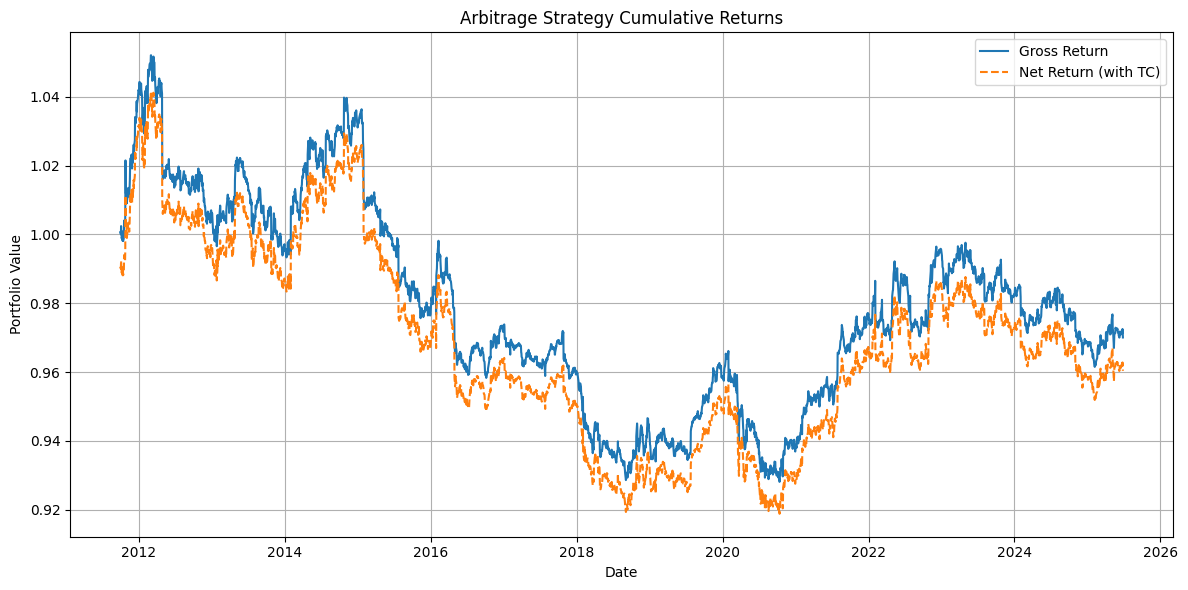

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(gross_return, label='Gross Return')
plt.plot(net_cum_return, label='Net Return (with TC)', linestyle='--')
plt.title("Arbitrage Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For the tech sector this strategy seems to work very badly (even worse with rebalancing)! 
But this reflects sector neutrality with a reduced number of great firms; we can see that the dynamic signal is quite unstable, and if we rely on a unique one we are shorting Amazon (obviously not smart in retrospect).

One-time portfolio build:  AAPL     0.041390
AMZN    -0.500000
GOOGL    0.206681
GTLB     0.000000
META     0.000000
MSFT     0.251928
Name: 2011-06-30 00:00:00, dtype: float64


<Axes: title={'center': 'Average Portfolio Exposure'}, xlabel='Date'>

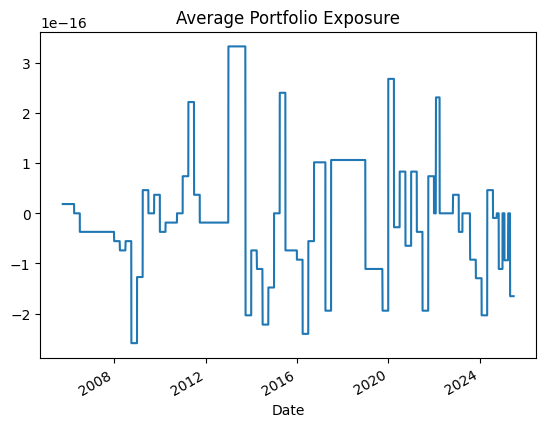

In [58]:
print("One-time portfolio build: ", initial_signal)

signal.mean(axis=1).plot(title="Average Portfolio Exposure")


Next, we will try and
- combine Free Cash Flow and possibly other fundamentals in the signal
- test progressive rebalancing strategies
- include nontech companies